## Setup imports

In [1]:
import os.path as osp
import sys
from __future__ import absolute_import
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
this_dir = osp.dirname('.')
lib_path = osp.join(this_dir, '..', 'lib')
add_path(lib_path)
add_path(osp.join(this_dir, '..'))

In [2]:
from models import build_model
from config import config
from config import _update_config_from_file
from dataset import build_dataloader
from core.function import only_forward

C:\Users\Saraansh\anaconda3\envs\gpl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import copy

## Set the config

In [4]:
# for only global model use:
# model_file = '../models/global.pth'
# _update_config_from_file(config, '..\experiments\global-inference.yaml')

# for only local model use:
# model_file = '../models/local.pth'
# _update_config_from_file(config, '..\experiments\local-inference.yaml')

# for global + local model use:
model_file = '../models/global_plus_local.pth'
_update_config_from_file(config, '..\experiments\global_plus_local-inference.yaml')

=> merge config from ..\experiments\global_plus_local-inference.yaml


## Setup the model

In [5]:
model = build_model(config)

In [6]:
state_dict = torch.load(model_file, map_location="cpu")
model.load_state_dict(state_dict, strict=True)
model

CVTDETR(
  (cvt): ConvolutionalVisionTransformerWithTokenOut(
    (stage0): VisionTransformer(
      (patch_embed): ConvEmbed(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (conv_proj_q): Sequential(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (rearrage): Rearrange('b c h w -> b (h w) c')
            )
            (conv_proj_k): Sequential(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
              (bn): BatchNorm2d(64, eps=1e-0

## Setup the dataloader

In [7]:
valid_loader = build_dataloader(config, False)

# data points in test/val dataset:  9


## Forward pass

In [8]:
results = only_forward(config, valid_loader, model)

Starting batch 0 ...
Starting batch 1 ...
Starting batch 2 ...
Starting batch 3 ...
Starting batch 4 ...
Starting batch 5 ...
Starting batch 6 ...
Starting batch 7 ...
Starting batch 8 ...


In [9]:
if 'global' in results.keys():
    print("Model generated Global embeddings with shape:", results['global'].shape)
if 'posori' in results.keys():
    print("Model performed Minutiae extraction with shape:", results['posori'].shape)
if 'embs' in results.keys():
    print("Model generated corresponding Minutiae embeddings with shape:", results['embs'].shape)

Model generated Global embeddings with shape: (9, 192)
Model performed Minutiae extraction with shape: (9, 50, 3)
Model generated corresponding Minutiae embeddings with shape: (9, 50, 64)


## Visualisations

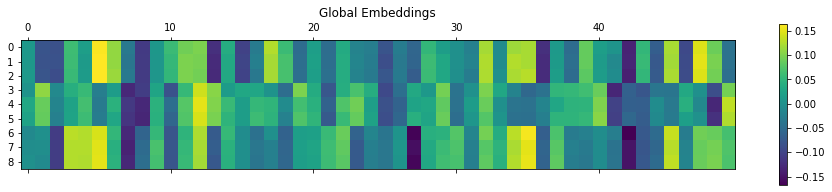

In [10]:
if 'global' in results.keys():
    plt.matshow(results['global'][:, :50])
    plt.title('Global Embeddings')
    plt.colorbar()
    plt.show()

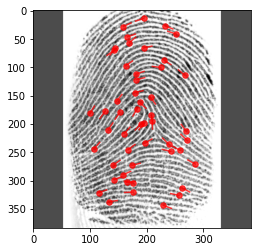

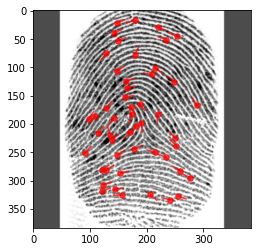

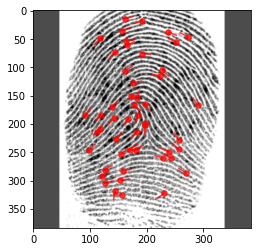

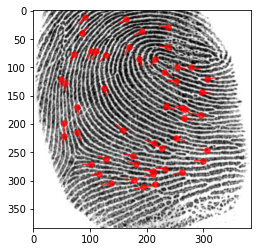

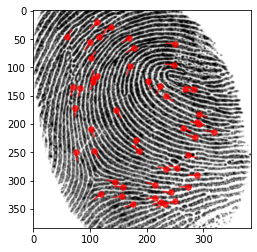

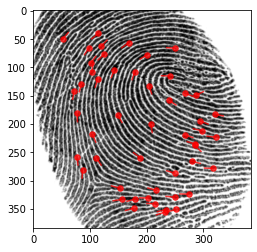

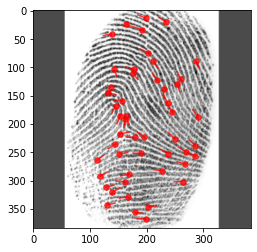

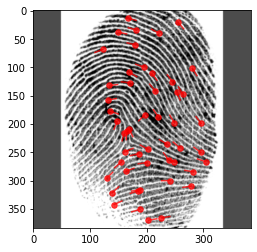

In [23]:
l = 15
for i, path in enumerate(valid_loader.dataset.imgs):
    img = Image.open(path).convert('RGB')
    img = valid_loader.dataset.transforms(img)[0]
    plt.imshow(img, cmap='gray')
    mnts = copy.deepcopy(results['posori'][i])
    mnts[:, 0] *= img.shape[0]
    mnts[:, 1] *= img.shape[1]
    mnts[:, 2] *= 2 * np.pi
    plt.scatter(mnts[:, 0], mnts[:, 1], color='red', s=30, alpha=0.75)
    for i in range(mnts.shape[0]):
        plt.plot((mnts[i, 0], mnts[i, 0] + l * np.cos(2*np.pi-mnts[i, 2])), (mnts[i, 1], mnts[i, 1] + l * np.sin(2*np.pi-mnts[i, 2])), color='red', alpha=0.75)
    plt.show()